<a href="https://colab.research.google.com/github/peternguyen24/NeuralNetworkBasic/blob/main/language/English_name_model_with_batchnorm_and_proper_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Video: https://www.youtube.com/watch?v=P6sfmUTpUmc&t=3566s

In [11]:
 words = open('/content/drive/MyDrive/Colab Notebooks/names.txt', 'r').read().splitlines()

In [12]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

#Part 1: Dataset

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
chars = set()
for word in words:
  for ch in word:
    chars.add(ch)
chars = sorted(list(chars))

stoi = {ch: idx+1 for idx, ch in enumerate(chars)}
stoi['.'] = 0

itos = {idx: ch for ch, idx in stoi.items()}
print(itos)
print(stoi)

VOCAB_SIZE = len(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [15]:
# BLOCK_SIZE = 3
# X, Y  = [], []

# for w in words:
#   # print(w)
#   context = [0] * BLOCK_SIZE
#   for ch in w + '.':
#     ix = stoi[ch]
#     X.append(context)
#     Y.append(ix)
#     # print(''.join(itos[i] for i in context), '--->', itos[ix])
#     context = context[1:] + [ix]

# X = torch.tensor(X)
# Y = torch.tensor(Y)
# data_size = X.nelement()

In [16]:
# X.shape, X.dtype, Y.shape, Y.dtype


In [17]:
# training split, validation split, test split
# 80% 10% 10%

BLOCK_SIZE = 3

def build_dataset(words):
  X, Y  = [], []
  for w in words:
  # print(w)
    context = [0] * BLOCK_SIZE
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]
  return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


# Training


In [52]:
# Initialization

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.01):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running + self.momentum * xmean
        self.running_var = (1 - self.momentum) * xvar + self.momentum * xmean
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

  def train(self):
    self.training = True

  def eval(self):
    self.training = False

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []



n_embd = 10 # the dementialnaity of the char embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility purpose

C = torch.randn((27, n_embd), generator=g)
layers = [
          Linear(n_embd * BLOCK_SIZE, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, n_hidden), Tanh(),
          Linear(n_hidden, VOCAB_SIZE),]


with torch.no_grad():
  layers[-1].weight *= 0.1 # gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True
print(sum(p.nelement() for p in parameters))


46497


In [53]:
# Optimization

MAX_STEPS = 200000
BATCH_SIZE = 32
lossi = []

for i in range(MAX_STEPS):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g) # Get the random indexes of 32 words from training data. shape = (32)
  Xb, Yb = Xtr[ix], Ytr[ix] # Get the actual (32, BLOCK_SIZE)

  # forward
  emb = C[Xb] # C.shape=(27,10) - 27 rows, each row is number of vector dimentionality. Xb.shape=(32, 3) -> C[Xb] = (32, 3, 10). 32 input, each input is 3 vector x 10 dimension
  x = emb.view(emb.shape[0], -1)  # -1 means infer from other dimension => x shape will be (32, 30) - 32 input, each vector of size 30
  for layer in layers:
    x = layer(x) # 32 x 30 -> 30 x 30 -> ... -> 30 x 27
  loss = F.cross_entropy(x, Yb)

  # backward
  for layer in layers:
    layer.out.retain_grad() # ensure that each layer record grad for backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{MAX_STEPS:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break # for debugging


      0/ 200000: 3.2865


layer 1 (      Tanh): mean -0.03, std 0.75, saturated: 19.41%
layer 3 (      Tanh): mean -0.02, std 0.70, saturated: 10.69%
layer 5 (      Tanh): mean -0.03, std 0.69, saturated: 9.47%
layer 7 (      Tanh): mean +0.04, std 0.66, saturated: 6.34%
layer 9 (      Tanh): mean +0.00, std 0.65, saturated: 6.22%


Text(0.5, 1.0, 'activation distribution')

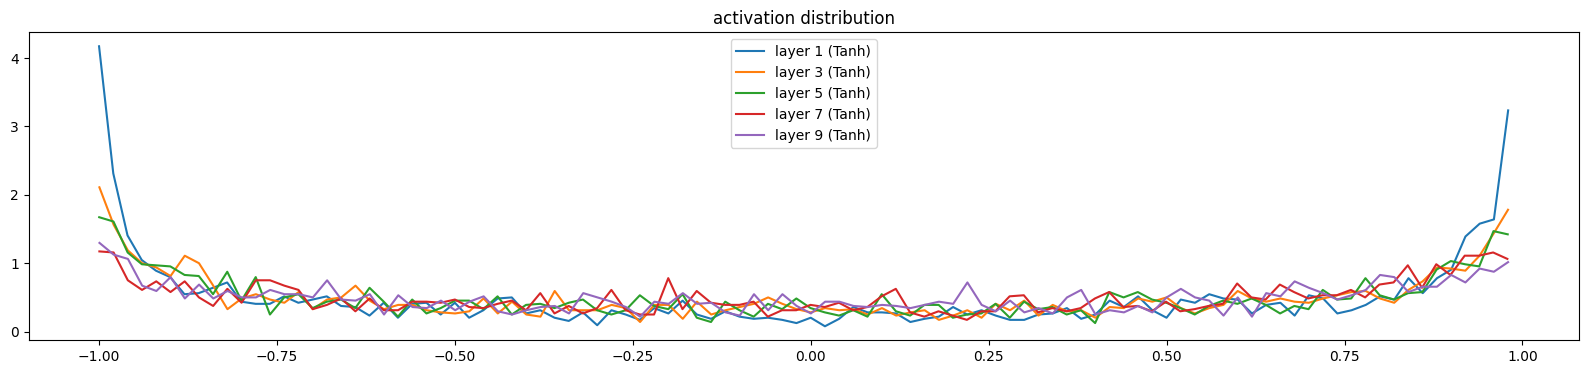

In [56]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density = True)
    # print(hx)
    # print(hy)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

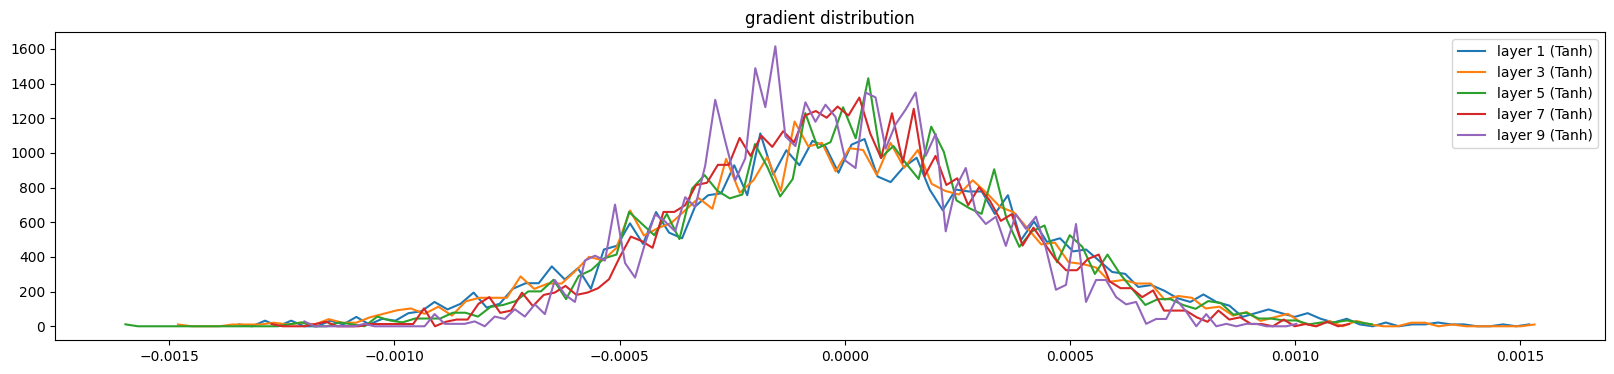

In [57]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density = True)
    # print(hx)
    # print(hy)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')